# Feature Engineering

En este notebook se buscan atributos nuevos para concatenar al set de datos original, así pudiendo armar un modelo predictivo más robusto y eficiente.



In [79]:
# Importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default')

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [80]:
df_train_labels = pd.read_csv('../data/train_labels.csv', low_memory=False)
df_train_values = pd.read_csv('../data/train_values.csv', low_memory=False)
df_test = pd.read_csv('../data/test_values.csv', index_col='building_id', low_memory=False)

In [81]:
df_train = pd.merge(df_train_labels, df_train_values, how='inner', on='building_id')
df_train.set_index('building_id', inplace=True)
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
28830,2,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
94947,3,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
590882,2,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
201944,3,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [82]:
df_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# Conversion de tipos de datos
to_categorical = set(df_train.select_dtypes(include='object').columns.tolist())
to_bool = set([col for col in df_train.columns if 'has' in col])
to_numeric = set(df_train.select_dtypes(include='int64').columns.tolist()) - to_bool

for col in to_categorical:
    df_train[col] = df_train[col].astype('category')

for col in to_bool:
    df_train[col] = df_train[col].astype('bool')

for col in to_numeric:
    df_train[col] = pd.to_numeric(df_train[col], downcast='unsigned')


In [84]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   damage_grade                            260601 non-null  uint8   
 1   geo_level_1_id                          260601 non-null  uint8   
 2   geo_level_2_id                          260601 non-null  uint16  
 3   geo_level_3_id                          260601 non-null  uint16  
 4   count_floors_pre_eq                     260601 non-null  uint8   
 5   age                                     260601 non-null  uint16  
 6   area_percentage                         260601 non-null  uint8   
 7   height_percentage                       260601 non-null  uint8   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                  

In [85]:
df_train.isnull().sum()

damage_grade                              0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [86]:
df_test.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

## Graficos de correlaciones entre variables con el dataset inicial

La columna has_secondary_use ya vimos que tiene informacion redundante con las de has_secondary_use_X

In [87]:
def drop_features_redundantes(df, features):
    df.drop(columns=features, inplace=True)

In [88]:
features_redundantes = ['has_secondary_use']
drop_features_redundantes(df_train, features_redundantes)

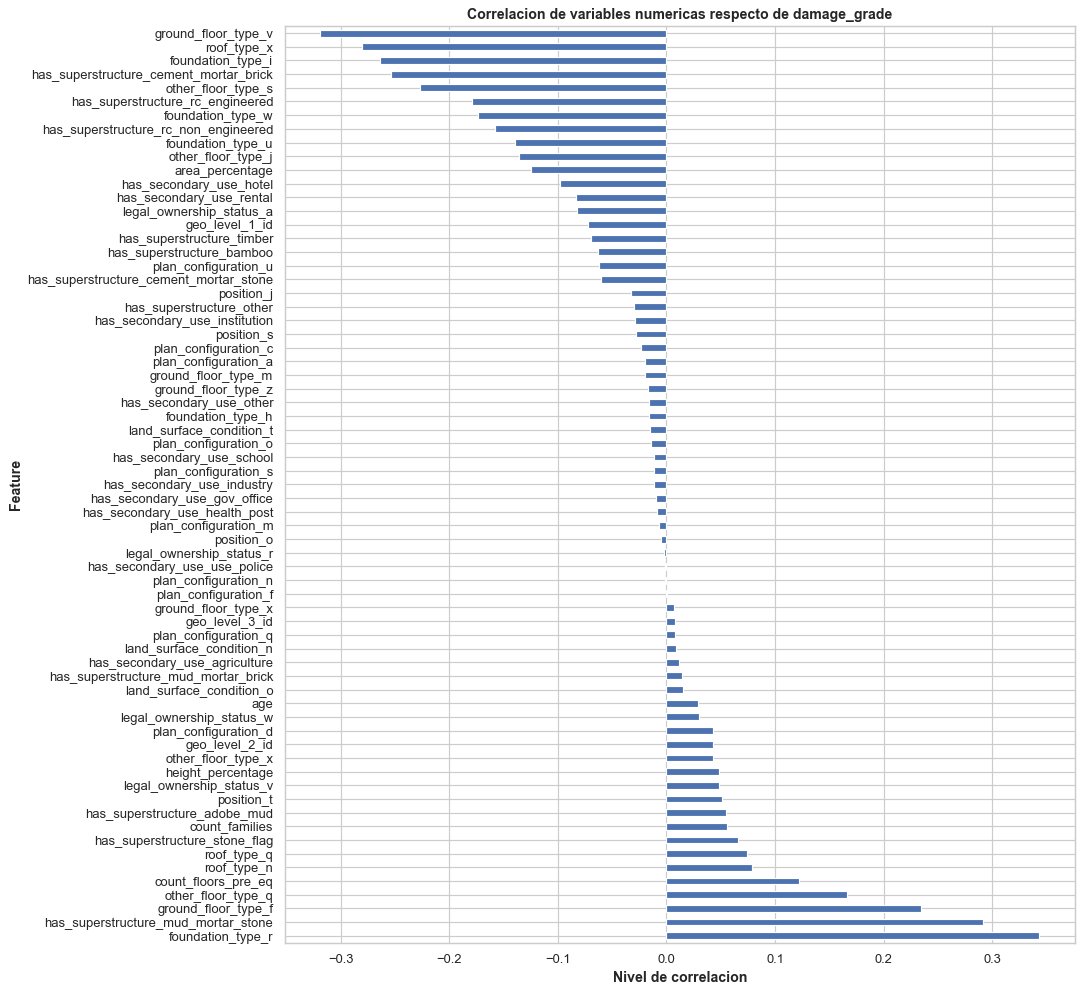

In [89]:
# Correlacion negativa --> una variable decrece mientras la otra crece o viceversa
# Correlacion positiva --> una varibale crece mientras la otra tambien, o las dos decrecen.

# Paso las features categoricas como columnas booleanas
features_categoricos = df_train.select_dtypes(include=['category']).columns.tolist()
df_con_categoricos = pd.get_dummies(df_train, prefix_sep='_', columns=features_categoricos, drop_first=False)

plt.figure(figsize=(12,14), dpi=85)
plt.title("Correlacion de variables numericas respecto de damage_grade", weight='bold')
df_con_categoricos.corr()['damage_grade'].drop('damage_grade').sort_values(ascending=False).plot.barh()
plt.ylabel('Feature', weight='bold')
plt.xlabel("Nivel de correlacion", weight='bold')
plt.show()

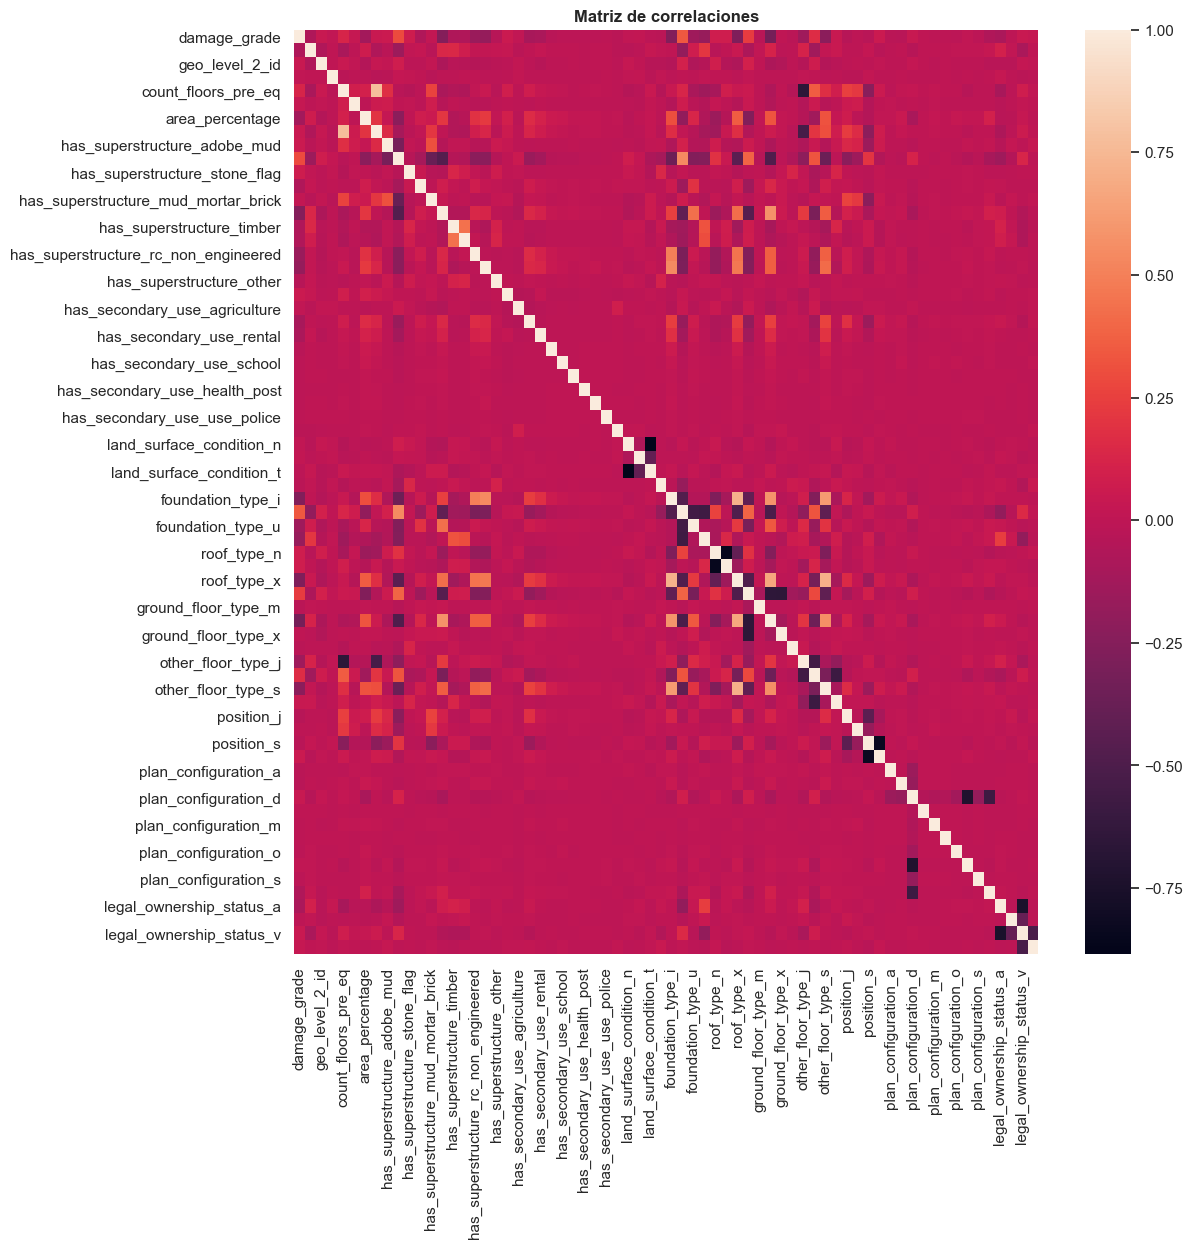

In [90]:
# Heatmap de correlaciones
plt.figure(figsize=(12, 12))
plt.title("Matriz de correlaciones", weight='bold')
sns.heatmap(df_con_categoricos.corr())
plt.show()

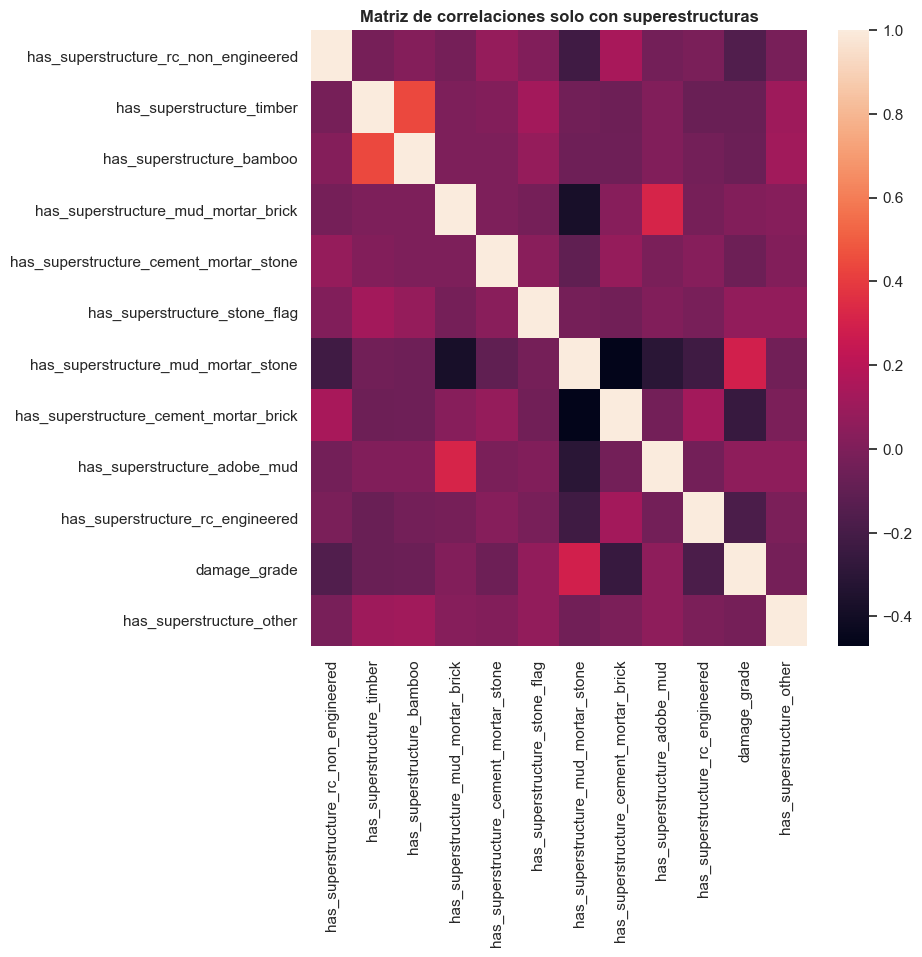

In [91]:
has_superstructure = set([col for col in df_train.columns if 'has_superstructure' in col]).union(set(['damage_grade']))
plt.figure(figsize=(8,8), dpi=100)
plt.title("Matriz de correlaciones solo con superestructuras", weight='bold')
sns.heatmap(df_train.loc[:, has_superstructure].corr())
plt.show()

## Creacion de nuevas features a partir de columnas actuales

### Trabajando con los geo_level_ids

Sabemos que los geo_level_ids tienen una alta cardinalidad para los tres tipos de IDs. Buscamos aplicar probabilidad condicional de manera de obtener, por ejemplo, 
$ P(damage\_grade = 1 \ | \ geo\_level\_1 = 14) $. Por ende, por cada columna de geo_level_id obtendriamos 3 nuevas features creando en total 9 nuevas columnas

In [92]:
# Vemos que cada columna suma 1.
test = pd.crosstab(df_train['damage_grade'], df_train['geo_level_1_id'], normalize='columns')
test

geo_level_1_id,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
damage_grade,,,,,,,,,,,,,,,,,,,,,
1,0.08,0.15,0.09,0.03,0.04,0.17,0.09,0.05,0.03,0.14,...,0.02,0.13,0.06,0.21,0.08,0.35,0.04,0.00,0.02,0.09
2,0.77,0.73,0.66,0.60,0.77,0.75,0.67,0.59,0.45,0.69,...,0.39,0.74,0.69,0.69,0.78,0.56,0.48,0.59,0.88,0.79
3,0.15,0.11,0.25,0.36,0.20,0.09,0.25,0.35,0.52,0.17,...,0.58,0.13,0.25,0.10,0.14,0.09,0.48,0.41,0.10,0.11


In [93]:
test[0]

damage_grade
1                   0.08
2                   0.77
3                   0.15
Name: 0, dtype: float64

In [94]:
# TODO: Antes de esto podriamos chequear la cardinalidad del geo level 3 y geo level 2 pq tienen muchos valores posibles
# los IDs que tienen pocos valores los podriamos agrupar.
# Tambien podriamos probar con algun encoder
def calcular_proba_condicional_segun_geo_level_id(df, feature_geo_level):
    proba_segun_danio_1 = []
    proba_segun_danio_2 = []
    proba_segun_danio_3 = []
    probas_condicionales = pd.crosstab(df['damage_grade'], df[feature_geo_level], normalize='columns')
    for _id in df[feature_geo_level]:
        proba_segun_danio_1.append(probas_condicionales[_id][1])
        proba_segun_danio_2.append(probas_condicionales[_id][2])
        proba_segun_danio_3.append(probas_condicionales[_id][3])
    label_spliteado = feature_geo_level.split('_')
    feature_geo_level = label_spliteado[0] + label_spliteado[1] + label_spliteado[2]
    df['proba_danio_1_dado_' + feature_geo_level] = proba_segun_danio_1
    df['proba_danio_2_dado_' + feature_geo_level] = proba_segun_danio_2
    df['proba_danio_3_dado_' + feature_geo_level] = proba_segun_danio_3        

In [95]:
# Tarda un poquito
calcular_proba_condicional_segun_geo_level_id(df_train, 'geo_level_1_id')
calcular_proba_condicional_segun_geo_level_id(df_train, 'geo_level_2_id')
calcular_proba_condicional_segun_geo_level_id(df_train, 'geo_level_3_id')

In [96]:
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,proba_danio_1_dado_geolevel1,proba_danio_2_dado_geolevel1,proba_danio_3_dado_geolevel1,proba_danio_1_dado_geolevel2,proba_danio_2_dado_geolevel2,proba_danio_3_dado_geolevel2,proba_danio_1_dado_geolevel3,proba_danio_2_dado_geolevel3,proba_danio_3_dado_geolevel3
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,False,0.09,0.67,0.25,0.00,0.25,0.74,0.00,0.16,0.84
28830,2,8,900,2812,2,10,8,7,o,r,...,False,0.03,0.45,0.52,0.01,0.49,0.50,0.06,0.81,0.12
94947,3,21,363,8973,2,10,5,5,t,r,...,False,0.02,0.39,0.58,0.08,0.32,0.60,0.03,0.36,0.61
590882,2,22,418,10694,2,10,6,5,t,r,...,False,0.13,0.74,0.13,0.02,0.85,0.13,0.03,0.84,0.13
201944,3,11,131,1488,3,30,8,9,t,r,...,False,0.05,0.57,0.38,0.03,0.59,0.38,0.01,0.61,0.38


### Features basadas en la antiguedad del edificio

In [97]:
def calcular_anio_edificacion(df):
    # Los datos fueron recolectados en 2015
    df['anio_edificacion'] = 2015 - df['age']
    # En Nepal en 1994 se crea el codigo de construccion a tener en cuenta para que
    # los edificios sean resistentes a terremetos
    df['construida_antes_de_codigo'] = 1994 < df['anio_edificacion']
    

In [98]:
calcular_anio_edificacion(df_train)
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,proba_danio_2_dado_geolevel1,proba_danio_3_dado_geolevel1,proba_danio_1_dado_geolevel2,proba_danio_2_dado_geolevel2,proba_danio_3_dado_geolevel2,proba_danio_1_dado_geolevel3,proba_danio_2_dado_geolevel3,proba_danio_3_dado_geolevel3,anio_edificacion,construida_antes_de_codigo
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0.67,0.25,0.00,0.25,0.74,0.00,0.16,0.84,1985,False
28830,2,8,900,2812,2,10,8,7,o,r,...,0.45,0.52,0.01,0.49,0.50,0.06,0.81,0.12,2005,True
94947,3,21,363,8973,2,10,5,5,t,r,...,0.39,0.58,0.08,0.32,0.60,0.03,0.36,0.61,2005,True
590882,2,22,418,10694,2,10,6,5,t,r,...,0.74,0.13,0.02,0.85,0.13,0.03,0.84,0.13,2005,True
201944,3,11,131,1488,3,30,8,9,t,r,...,0.57,0.38,0.03,0.59,0.38,0.01,0.61,0.38,1985,False


In [99]:
df_train['construida_antes_de_codigo'].value_counts()

True     166826
False     93775
Name: construida_antes_de_codigo, dtype: int64

### Features basados en cantidad de pisos, area, altura y cantidad de familias

In [100]:
# En algunos casos hago df['age'] + 0.15 ya que hay casos con 0 años de antiguedad
# El tema es que en algunos casos da valores alto, por ahora lo dejo asi pero se puede sacar
def features_basadas_en_cantidad_de_pisos(df):
    df['cant_pisos_por_antiguedad'] = df['count_floors_pre_eq'] / (df['age'] + 0.15)
    df['cant_pisos_por_area'] = df['count_floors_pre_eq'] / df['area_percentage']
    df['cant_pisos_por_altura'] = df['count_floors_pre_eq'] / df['height_percentage']
    
def features_basadas_en_area_altura(df):
    df['area_por_antiguedad'] = df['area_percentage'] / (df['age'] + 0.15)
    df['altura_por_antiguedad'] = df['height_percentage'] / (df['age'] + 0.15)
    df['area_por_altura'] = df['area_percentage'] / df['height_percentage']
    df['producto_area_altura'] = df['area_percentage'] * df['height_percentage']
    df['area_al_cuadrado'] = df['area_percentage'] ** 2
    df['altura_al_cuadrado'] = df['height_percentage'] ** 2
    df['promedio_area_altura'] = (df['area_percentage'] + df['height_percentage']) / 2

def features_basadas_en_cantidad_familias(df):
    df['cant_familias_por_pisos'] = df['count_families'] / df['count_floors_pre_eq']
    df['cant_familias_por_area'] = df['count_families'] / df['area_percentage']
    df['cant_familias_por_altura'] = df['count_families'] / df['height_percentage']

In [101]:
features_basadas_en_cantidad_de_pisos(df_train)
features_basadas_en_area_altura(df_train)
features_basadas_en_cantidad_familias(df_train)
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,area_por_antiguedad,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0.20,0.17,1.20,30,36,25,5.50,0.50,0.17,0.20
28830,2,8,900,2812,2,10,8,7,o,r,...,0.79,0.69,1.14,56,64,49,7.50,0.50,0.12,0.14
94947,3,21,363,8973,2,10,5,5,t,r,...,0.49,0.49,1.00,25,25,25,5.00,0.50,0.20,0.20
590882,2,22,418,10694,2,10,6,5,t,r,...,0.59,0.49,1.20,30,36,25,5.50,0.50,0.17,0.20
201944,3,11,131,1488,3,30,8,9,t,r,...,0.27,0.30,0.89,72,64,81,8.50,0.33,0.12,0.11


### Features basados en uso secundario y tipo de superestructura

In [102]:
def features_basados_en_superestructura(df):
    has_superstructure = set([col for col in df.columns if 'has_superstructure' in col])
    only_superstructure = df.loc[:, has_superstructure]
    only_superstructure['cant_materiales'] = only_superstructure.sum(axis=1, numeric_only=True)
    result = df.join(only_superstructure['cant_materiales'], on='building_id')
    return result

In [103]:
df_train = features_basados_en_superestructura(df_train)
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0.17,1.20,30,36,25,5.50,0.50,0.17,0.20,2
28830,2,8,900,2812,2,10,8,7,o,r,...,0.69,1.14,56,64,49,7.50,0.50,0.12,0.14,1
94947,3,21,363,8973,2,10,5,5,t,r,...,0.49,1.00,25,25,25,5.00,0.50,0.20,0.20,1
590882,2,22,418,10694,2,10,6,5,t,r,...,0.49,1.20,30,36,25,5.50,0.50,0.17,0.20,3
201944,3,11,131,1488,3,30,8,9,t,r,...,0.30,0.89,72,64,81,8.50,0.33,0.12,0.11,1


### Encoding de variables categoricas

> https://contrib.scikit-learn.org/category_encoders/

In [104]:
# land_surface_condition tiene 3 tipos
# foundation_type tiene 5 tipos
# roof_type tiene 3 tipos
# ground_floor_type tiene 5 tipos
# other_floor_type tiene 4 tipos
# position tiene 4 tipos
# plan_configuration tiene 10 tipos, tenemos que tener cuidado.
# legal_ownership_status tiene 4 tipos

df_train['plan_configuration'].value_counts()

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

In [116]:
from category_encoders import OneHotEncoder

def apply_one_hot_encoding(df_train, df_test):
    '''
    Aplica one hot encoding a los labels seleccionados.
    Tener cuidado que un label NO tenga demasiados tipos de valores posibles.
    '''
    cat_features = set(df_train.select_dtypes(include='category').columns.tolist())
    ohe_enc = OneHotEncoder(cols=cat_features, use_cat_names=True)
    ohe_train = ohe_enc.fit_transform(df_train[cat_features])
    ohe_test = ohe_enc.transform(df_test[cat_features])
    to_train = df_train.join(ohe_train)
    to_test = df_test.join(ohe_test)
    to_train.drop(columns=cat_features, inplace=True)
    to_test.drop(columns=cat_features, inplace=True)
    return to_train, to_test

In [117]:
df_train, df_test = apply_one_hot_encoding(df_train, df_test)

In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 93 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   damage_grade                            260601 non-null  uint8  
 1   geo_level_1_id                          260601 non-null  uint8  
 2   geo_level_2_id                          260601 non-null  uint16 
 3   geo_level_3_id                          260601 non-null  uint16 
 4   count_floors_pre_eq                     260601 non-null  uint8  
 5   age                                     260601 non-null  uint16 
 6   area_percentage                         260601 non-null  uint8  
 7   height_percentage                       260601 non-null  uint8  
 8   has_superstructure_adobe_mud            260601 non-null  bool   
 9   has_superstructure_mud_mortar_stone     260601 non-null  bool   
 10  has_superstructure_stone_flag          

In [119]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 68 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   geo_level_1_id                          86868 non-null  int64
 1   geo_level_2_id                          86868 non-null  int64
 2   geo_level_3_id                          86868 non-null  int64
 3   count_floors_pre_eq                     86868 non-null  int64
 4   age                                     86868 non-null  int64
 5   area_percentage                         86868 non-null  int64
 6   height_percentage                       86868 non-null  int64
 7   has_superstructure_adobe_mud            86868 non-null  int64
 8   has_superstructure_mud_mortar_stone     86868 non-null  int64
 9   has_superstructure_stone_flag           86868 non-null  int64
 10  has_superstructure_cement_mortar_stone  86868 non-null  int64
 11  has_super

### Transformando el set de test para utilizacion de los modelos